# Model Comparison Notebook
##### Combine prediction results from all models and compare against actual test values

In [1]:
# Importing the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# Split Dataframe into train and test set
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

In [3]:
# Get Lost/Kept Ticker Lists
lost_figs = np.array(["PBI","ABT","WRE","HP"])
kept_figs = np.array(["MGEE","TGT","BEN","CBSH"])

# Get data for each of the 3 models
lstm_lost = np.array([np.load(f"data/numpy/{i}_pred_lstm_lag.npy") for i in lost_figs],dtype=object)
lstm_kept = np.array([np.load(f"data/numpy/{i}_pred_lstm_lag.npy") for i in kept_figs],dtype=object)

arima_lost = np.array([np.load(f"data/numpy/{i}_pred_arima.npy") for i in lost_figs],dtype=object)
arima_kept = np.array([np.load(f"data/numpy/{i}_pred_arima.npy") for i in kept_figs],dtype=object)

af_lost = np.array([np.load(f"data/numpy/{i}_pred_af.npy") for i in lost_figs],dtype=object)
af_kept = np.array([np.load(f"data/numpy/{i}_pred_af.npy") for i in kept_figs],dtype=object)

In [4]:
# Load and store data in initial Dataframe
df_lost = {}
df_kept = {}

for i in lost_figs:
    df_lost[i] = pd.read_csv("data/series/good/" + i + "_dividends_fixed.csv", index_col="Date", parse_dates=["Date"])
for i in kept_figs:
    df_kept[i] = pd.read_csv("data/series/good/" + i + "_dividends_fixed.csv", index_col="Date", parse_dates=["Date"])
    
    
# Create new Dataframe that contains test data for each company
# split at specified year
df_lost_test = {}
df_kept_test = {}
for i in lost_figs:
    _, df_lost_test[i] = split(df_lost[i], "2006", "0")

for i in kept_figs:
    _, df_kept_test[i] = split(df_kept[i], "2006", "0")

In [5]:
# Get appropriate date values for the LSTM model
overlap = 5
test_count = 60

lost_dates = {}
kept_dates = {}
for j in lost_figs:
        y_test = []   
        lost_dates[j] = []
        for i in range(overlap, test_count):
            lost_dates[j].append(df_lost_test[j].index[i])
        

for j in kept_figs:
        y_test = []   
        kept_dates[j] = []
        for i in range(overlap, test_count):
            kept_dates[j].append(df_kept_test[j].index[i])          

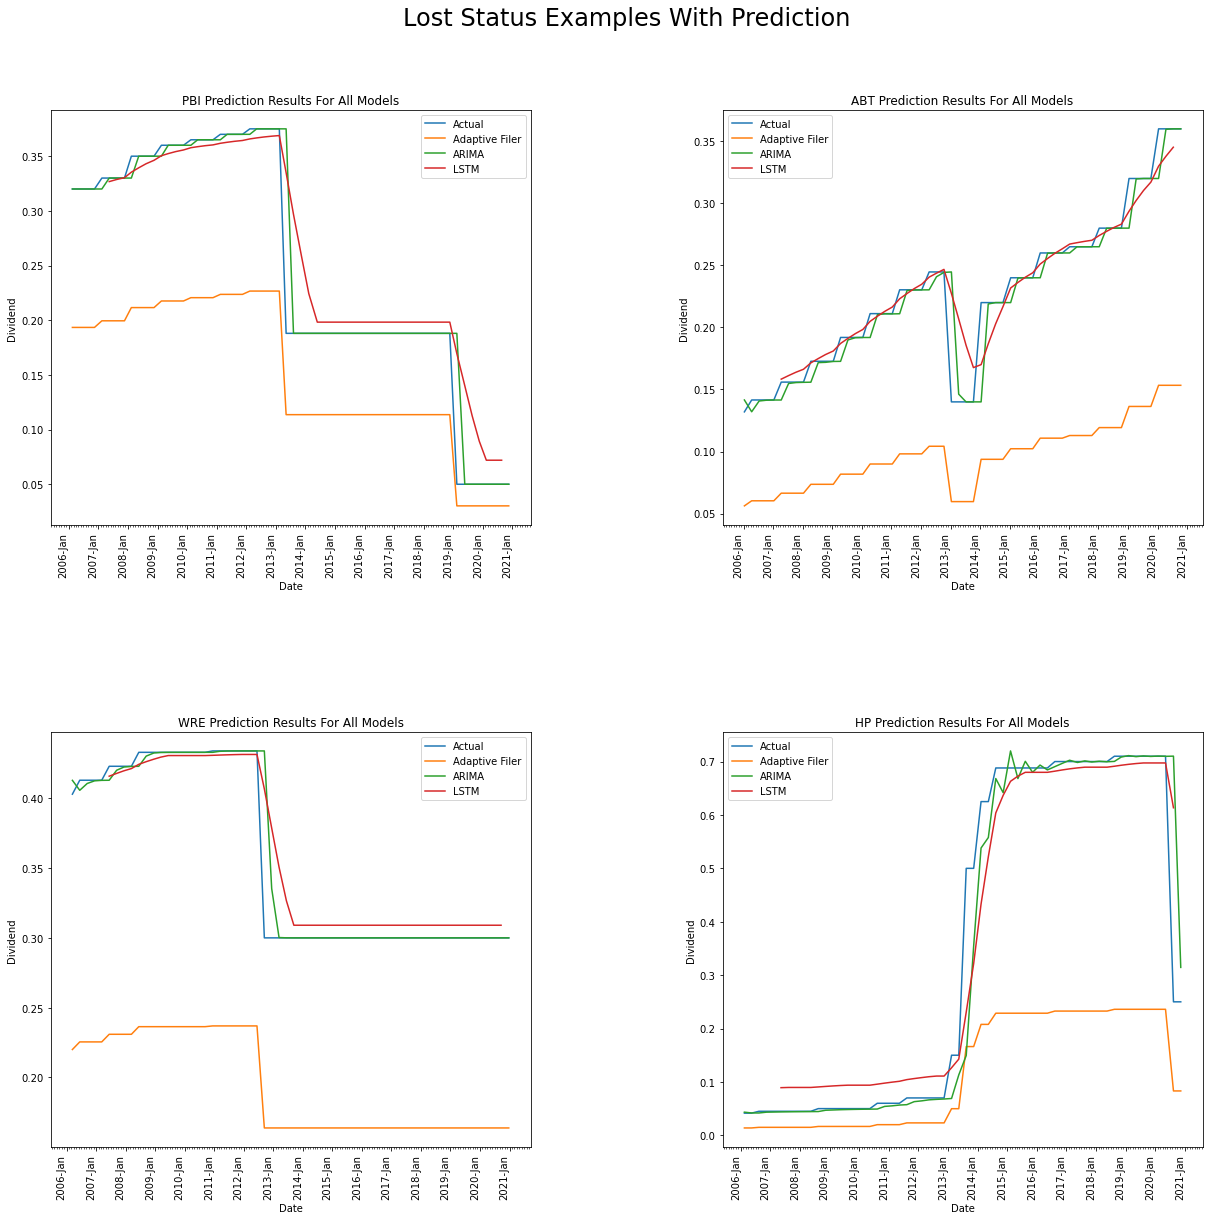

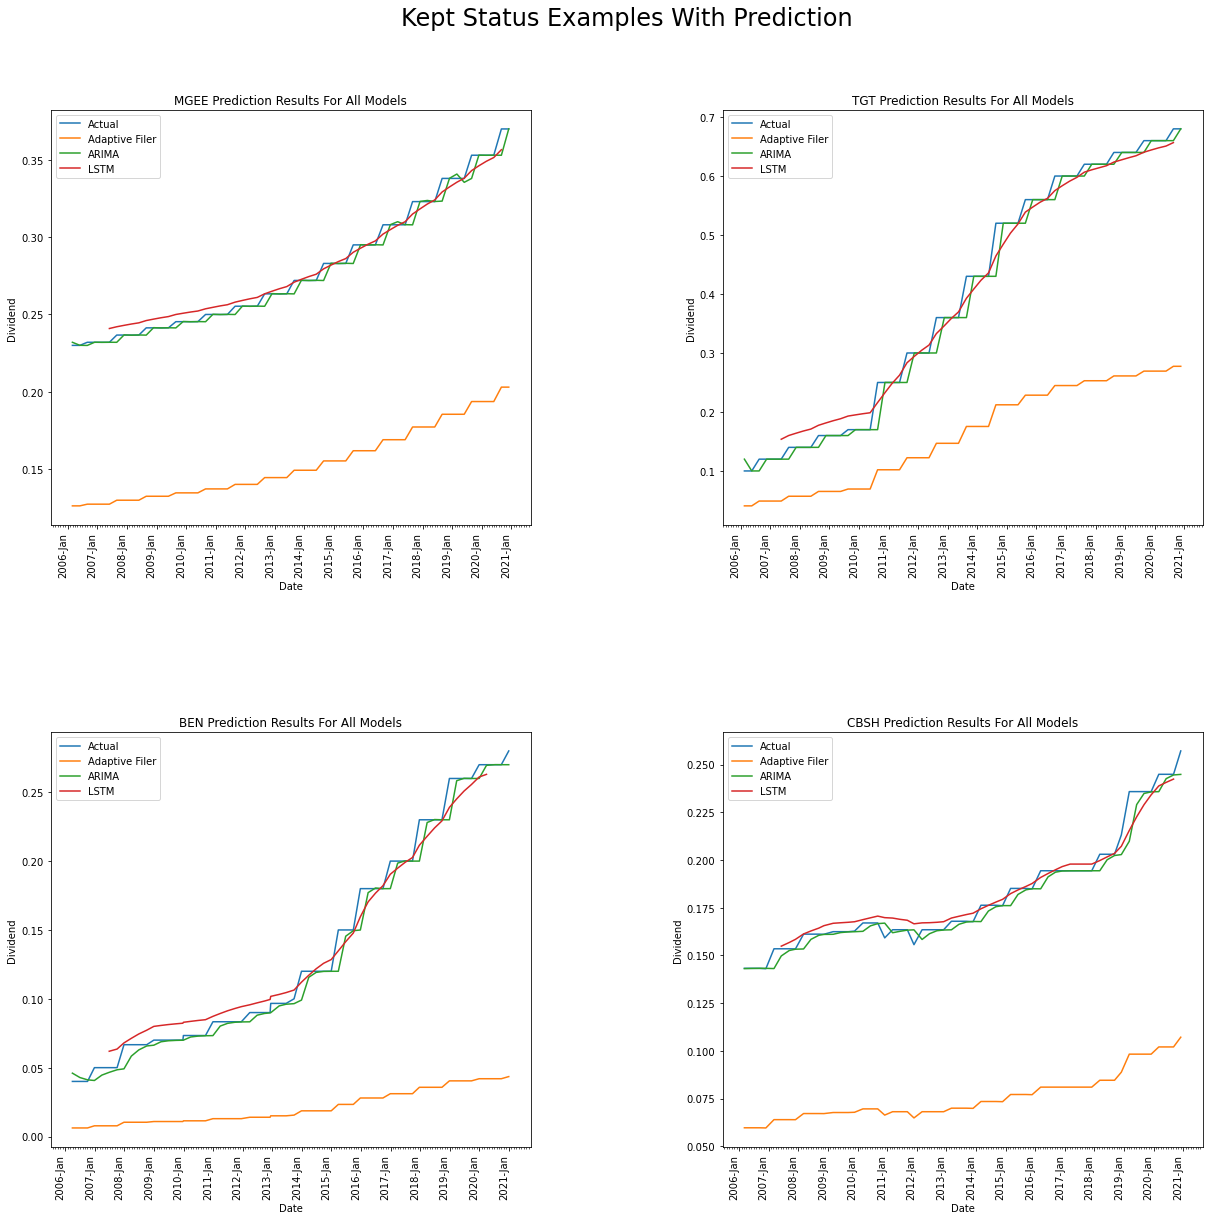

In [6]:
# Plot Model Comparison on Selected Lost/Kept Status Examples

lost_fig, lost_axs = plt.subplots(2,2,figsize=(20, 18))        
lost_fig.suptitle("Lost Status Examples With Prediction", fontsize=24)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)


kept_fig, kept_axs = plt.subplots(2,2,figsize=(20, 18))        
kept_fig.suptitle("Kept Status Examples With Prediction", fontsize=24)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

lost_ct = 0
kept_ct = 0

for i in np.concatenate([lost_figs,kept_figs]):        

        if i in lost_figs:
        
            arima = arima_lost[lost_figs==i][0]
            lstm = lstm_lost[lost_figs==i][0]
            af = af_lost[lost_figs==i][0]
            
            indx = lost_ct
            axs = lost_axs.flat
            axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
            axs[indx].xaxis.set_minor_locator(mdates.MonthLocator())
            axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
            axs[indx].plot(df_lost_test[i])
            axs[indx].plot(df_lost_test[i].index, af)
            axs[indx].plot(df_lost_test[i].index, arima)
            axs[indx].plot(pd.DatetimeIndex(lost_dates[i]),lstm)
            axs[indx].set_ylabel("Dividend")
            axs[indx].set_xlabel("Date")
            for label in axs[indx].get_xticklabels(which='major'):
                label.set(rotation=90, horizontalalignment='right')
            axs[indx].legend(["Actual", "Adaptive Filer", "ARIMA", "LSTM"])
            axs[indx].set_title("{} Prediction Results For All Models".format(i))
            extent = axs[indx].get_window_extent().transformed(lost_fig.dpi_scale_trans.inverted())
            lost_fig.savefig(f"{i}_Prediction_All.png", format="png", bbox_inches=extent.expanded(1.3, 1.35)) 
            lost_ct += 1

        if i in kept_figs:
            
        
            arima = arima_kept[kept_figs==i][0]
            lstm = lstm_kept[kept_figs==i][0]
            af = af_kept[kept_figs==i][0]          
            
            indx = kept_ct
            axs = kept_axs.flat
            axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
            axs[indx].xaxis.set_minor_locator(mdates.MonthLocator())
            axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b')) 
            axs[indx].plot(df_kept_test[i])
            axs[indx].plot(df_kept_test[i].index, af)
            axs[indx].plot(df_kept_test[i].index, arima)
            axs[indx].plot(pd.DatetimeIndex(kept_dates[i]),lstm)
            axs[indx].set_ylabel("Dividend")
            axs[indx].set_xlabel("Date")
            for label in axs[indx].get_xticklabels(which='major'):
                label.set(rotation=90, horizontalalignment='right')
            axs[indx].legend(["Actual", "Adaptive Filer", "ARIMA", "LSTM"])
            axs[indx].set_title("{} Prediction Results For All Models".format(i))
            extent = axs[indx].get_window_extent().transformed(kept_fig.dpi_scale_trans.inverted())
            kept_fig.savefig(f"{i}_Prediction_All.png", format="png", bbox_inches=extent.expanded(1.3, 1.35))
            
            kept_ct+=1

plt.show()